# Adaptive Echo Cancellation

In this notebook we will use the adaptive LMS filter to estimate the response of a reverberating room; in handsfree telephony this is necessary because the received signal, played by the speaker, is picked up by the microphone. This feedback needs to be eliminated from the transmitted signal but a simple subtraction does not suffice because the signal picked up by the microphone contains echoes due to the reflections with the walls in the room.

The same setup can be used to combat the effects of a a communication channel that introduces multiples echos.

In [152]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from scipy.io import wavfile

In [153]:
plt.rcParams["figure.figsize"] = (14,4)

## The echo model

Let's begin by implementing an echo filter that simulates the reverbereation in a room. 

Let's begin by implementing an echo filter that simulates the reverbereation in a room. We will use a recursive model in which each reflection introduces a 180-degree phase shift (i.e. a change in sign) together with attenuation and lowpass filtering.

<img width="750" style="margin: 10px 20px 0 0;" src="echo.jpg">

In the above block diagram, $M$ is the echo's delay, $-1 < \alpha < 0$ is the attenuation factor for each repetition and $H(z) = (1-\lambda)/(1 - \lambda z^{-1})$ is a simple leaky integrator with $\lambda$ relatively small in order to just attenuate more and more the signal with each reflection.

The CCDE governing the system turns out to be 

$$
    y[n] = x[n] − \lambda x[n − 1] + \lambda y[n − 1] + \alpha (1 − \lambda)y[n − M]
$$

which is easily implemented as follows:

In [154]:
def echo(x, M, lmb=0.6, alpha=-0.8):
    # if the first argument is a scalar, assume the input is a delta sequence of length x
    #  in this case, the function returns the truncated impulse response of the room.
    if np.isscalar(x):
        x = np.zeros(int(x))
        x[0] = 1
    y = np.zeros(len(x))
    for n in range(0, len(x)):
        if n >= M:
            y[n] = x[n] - lmb * x[n-1] + lmb * y[n-1] + alpha * (1 - lmb) * y[n - M]
        elif n > 0:
            y[n] = x[n] - lmb * x[n-1] + lmb * y[n-1]
        else:
            y[n] = x[n]
    return y

Let's look at the impulse response of the echo "system" for $M$ small 

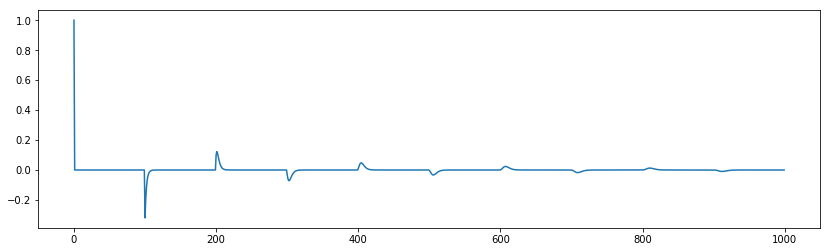

In [157]:
plt.plot(echo(1000, 100));

We will compare the convergence properties of the LMS algorithm both for noise-like signals and for voice signals. Let's load a brief speech sample that we will use in the rest of the notebook. 

In [158]:
Fs, s = wavfile.read('speech2.wav')
s = s / 32767.0 # scale the signal to floats in [-1, 1]
print('sampling rate:', Fs, 'Hz, data length:', len(s), 'samples')
IPython.display.Audio(s, rate=Fs)

sampling rate: 8000 Hz, data length: 19063 samples


For audio signals, that's how the reverberation sounds for a delay to about 20ms

In [201]:
es = echo(s, int(0.020 * Fs))
IPython.display.Audio(es, rate=Fs)

and we can easily convince ourselves that simple subtraction will not work; here we play the signal with echo first to compare volume levels.

In [166]:
IPython.display.Audio(np.r_[es, es - s], rate=Fs)

## The LMS filter

Let's now implement the LMS filter for echo cancellation. Given the original signal $x[n]$ and its echo-corrupted version $d[n] = h[n] \ast x[n]$, the LMS algorithm will estimate $h[n]$ iteratively as

\begin{align}
  e[n] &= d[n] - \mathbf{h}_{n}^{T} \mathbf{x}_n \\
  \mathbf{h}_{n+1} &= \mathbf{h}_n + \alpha_n\, e[n] \, \mathbf{x}_n
\end{align}

where $\mathbf{h}_n$ is the set of estimated filter coefficients at iteration $n$:
$$\mathbf{h}_n = \begin{bmatrix} h_n[0] & h_n[1] & h_n[2] & \ldots & h_n[N-1] \end{bmatrix}$$
and where
$$\mathbf{x}_n = \begin{bmatrix} x[n] & x[n-1] & x[n-2] & \ldots & x[n - N + 1] \end{bmatrix}$$

In [8]:
def lms(x, d, N, a=0.001):
    # Run the LMS adaptation using x as the input signal, d as the desired output signal and a as the step size
    # Will return an N-tap FIR filter
    #
    # initial guess for the filter is a delta
    h = delta(N)
    # number of iterations
    L = min(len(x), len(d))
    # let's store the error at each iteration to plot the MSE
    e = np.zeros(L)
    # run the adaptation
    for n in range(N, L):
        e[n] = d[n] - np.dot(h, x[n:n-N:-1])
        h = h + a * e[n] * x[n:n-N:-1]
    return h, e[N:]

We will first test the LMS filter using unit-variance white Gaussian noise as the input signal. With this maximally decorrelated input the convergence is faster. First, let's verify that the filter converges to a good approximation of the echo's impulse response:

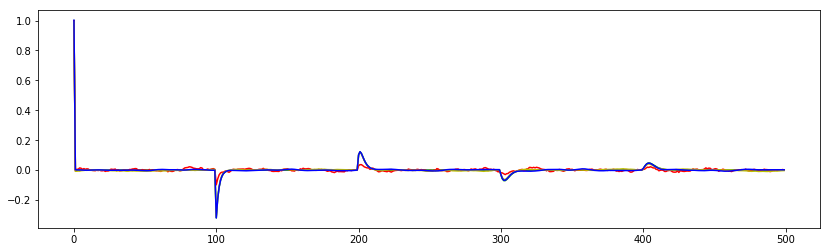

In [162]:
# echo delay
delay = 100

# LMS parameters
taps = 500
step_size = 0.0008

# this function generates runs the LMS adaptation on a signal of length L and returns the filter's coefficients
def test_lms(L):
    # the input signal
    ns = np.random.randn(L)
    return lms(ns, echo(ns, delay), taps, step_size)[0]
    
h = echo(taps, delay)
# precision increases with length of the adaptation 
plt.plot(h, 'g'); # original impulse response (green)
plt.plot(test_lms(1000), 'r');
plt.plot(test_lms(5000), 'y');
best = test_lms(10000)
plt.plot(best, 'b');


The approximation obtained with the highest number of iterations is actually quite good, as we can see by plotting the difference between the original and the estimated impulse response:

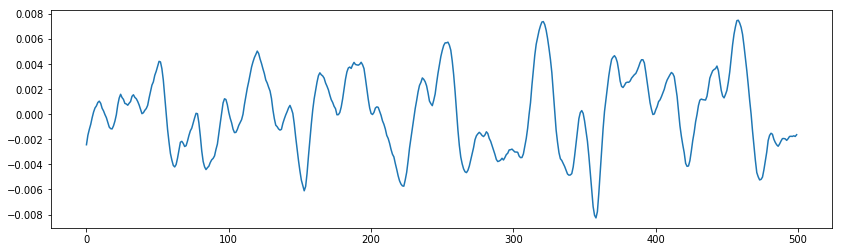

In [163]:
plt.plot(h - best);

Clearly the precision depends on the number of steps in the adaptation. You can try and play with the value of the step size, for instance, and see how it affects the convergence.

To have a quantitative descrition of the convergence process we can plot the MSE, averaged over a number of independent experiments.

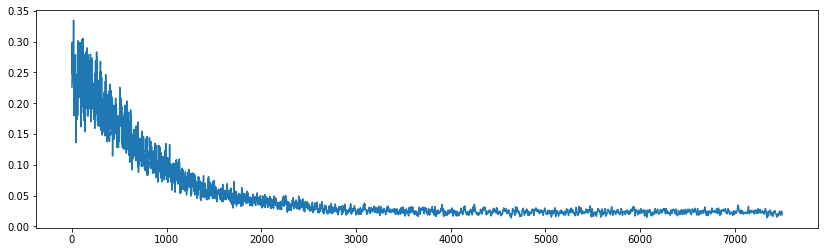

In [164]:
TRIALS = 100
L = 8000

for n in range(0, TRIALS):
    ns = np.random.randn(L)
    err = np.square(lms(ns, echo(ns, delay), taps, step_size)[1]) 
    if n == 0:
        mse = err
    else:
        mse = mse + err
mse = mse / TRIALS   
plt.plot(mse);

As you can see, with these parameters the error stops decreasing after about 4000 iterations. 

## The echo canceler

Let's now run the LMS adaptation using a voice signal as the input. Since the voice signal is very correlated, the convergenge will be slower, but we can use a much larger step size. Since our sound snippet is short, we will use it multiple times in the adaptation.

In [252]:
# let's build the echo signal with a 20ms delay
delay = int(0.020 * Fs)
audio = np.r_[s, s, s, s, s]

# now let's estimate the first 1000 taps of the echo impulse response using the speech signal
taps = 1500
step_size = 0.021
h, err = lms(audio, echo(audio, delay), taps, step_size)

If we plot the difference between the ideal and estimated impulse response we can see that the match is not perfect. This is because the speech signal, as opposed to white noise, does not drive the adaptation as effectively since it doesn't "hit" all of the frequencies. You can try and use more copies of the audio in sequence to improve the adaptation; in a normal use case the LMS filter would be running all the time, using much more data to converge.

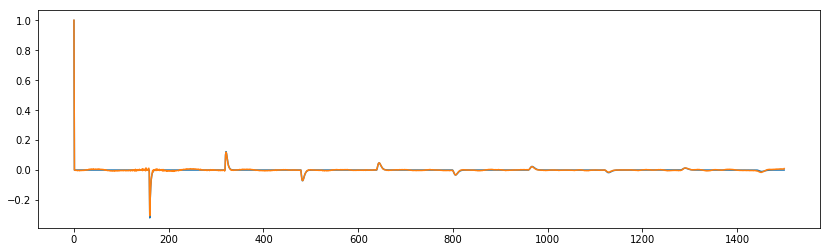

In [253]:
plt.plot(echo(len(h), delay));
plt.plot(h);

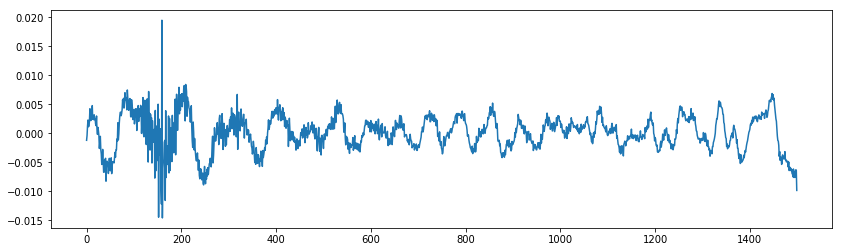

In [254]:
plt.plot(echo(len(h), delay) - h);

We can now listen to the effectiveness of the echo canceler; listen in sequence to the reverberated sound, the cancellation performed by simple subtraction and the cancellation after filtering with the coefficients produced by the LMS adaptation. The results should speak for themselves!

In [255]:
es = echo(s, delay)
IPython.display.Audio(np.r_[es, es - s, es - sp.lfilter(h, 1, s)], rate=Fs)

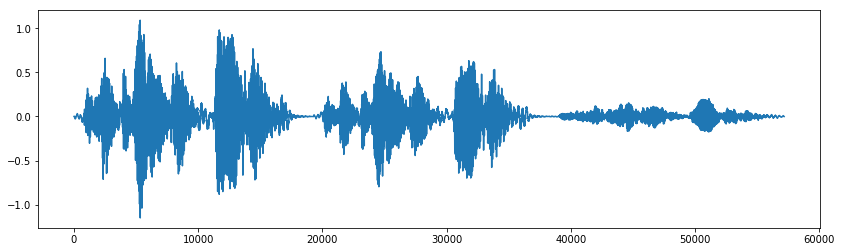

In [256]:
plt.plot(np.r_[es, es - s, es - sp.lfilter(h, 1, s)]);